In [97]:
import json
from collections import Counter
from tqdm.notebook import tqdm

# Maybe add military
# Used wordnet to get additional synonyms
# 'resist', 'dissent',
protest_key_words = set([
    'protest', 'protesters', 'protester',
    'demonstration', 'demonstrations', 'demonstrators', 'demonstrator',
    'clash', 'clashes', 'skirmish', 'skirmishes',
    'riot', 'riots',
    'barricades', 'barricade', 'barricaded', 'roadblock',
    'tear', 'gas',
    'unrest', 'unrests',
    'revolt',
    'upheaval', 'turmoil', 'agitation', 'agitate',
    'uproar',
    'resist', 'resisted', 'arrested', 'arrests',
    'manifestation', 'manifestations',
    'police', 'officers', 'officer', 'force', 'forces',
])
# Removed long (HK), yellow(France), avenue (France), latin (Venezuela)
protest_specific_key_words = {
'Venezuela':['maduro', 'guaido', 'venezuela', 'caracas', 'venezuelan', 'juan', 'venezuelans', 'nicolas', 'lopez', 'chavez', 'cabello', 'leopoldo', 'diosdado', 'hyperinflation', 'shortages', 'cucuta', 'hugo', 'padrino'],
'France':['paris', 'macron', 'gilets', 'jaunes', 'jaune', 'gilet', 'french', 'france', 'champs', 'elysees', 'vest', 'vests', 'arc', 'triomphe', 'emmanuel', 'christophe', 'castaner', 'jackets', 'philippe', 'elysee', 'marseille', 'michel', 'edouard', 'lyon'],
'Hong Kong':['hong', 'kong', 'china', 'lam', 'chinese', 'extradition', 'beijing', 'mainland', 'carrie', 'wong', 'yuen', 'cheung', 'chan', 'communist', 'xi', 'kowloon', 'xinjiang', 'kongers', 'chinese'],
'Iran':['iran', 'iranian', 'tehran', 'soleimani', 'khamenei', 'irgc', 'ali', 'ayatollah', 'fadavi', 'drone', 'iranians', 'irbil', 'erbil', 'rouhani', 'mousavi', 'khuzestan', 'persian', 'zarif']
}

confounders = set(['latin', 'bolivia', 'bolivian'])

with open('unfiltered_articles.json') as articles_fh:
    unfiltered_articles = json.load(articles_fh)

Counter([article['source']['title'] for article in unfiltered_articles])

Counter({'The New York Times': 8217,
         'CNN International': 2818,
         'VOA Voice of America': 2511,
         'Fox News': 5012,
         'Global Times': 350,
         'South China Morning Post': 5568,
         'Hong Kong Free Press HKFP': 1013,
         'China Daily': 3652,
         'France 24': 4412,
         'Agence France-Presse': 5578,
         'Iran daily': 1996,
         'Tehran Times': 650,
         'IFPnews': 281,
         'Entorno Inteligente': 2095,
         'Latin American Herald Tribune': 2244,
         'Sputnik': 5085,
         'RT': 2298,
         'The Moscow Times': 371,
         'Meduza': 409,
         'Al Jazeera English': 4117})

In [98]:
import unidecode
import re
from nltk.stem.snowball import PorterStemmer
from collections import defaultdict


def keywordCounter(tokenized_article, labeled_kws, protest_kw):
    keyword_counts = defaultdict(lambda: 0)
    label_counts = defaultdict(lambda: 0)
    protest_counts = 0
    for tok in tokenized_article:
        for label, key_words in labeled_kws.items():
            if tok in key_words:
                label_counts[label] += 1
                keyword_counts[tok] +=1
        if tok in protest_kw:
            protest_counts += 1
    return keyword_counts, label_counts, protest_counts

def preprocess_text(text, split=True, stem=True):
    text = text.lower()
    # Convert to ascii
    text = unidecode.unidecode(text)
    if split:
        text = re.split('!?\.?,?;?;?\s+', text) #text.split() #[token for token in nlp(text)]
    if stem:
        stemmer = PorterStemmer()
        text = [stemmer.stem(tok) for tok in text]
    return text



In [99]:
processed_articles = [preprocess_text(article['body'], stem=False) for article in tqdm(unfiltered_articles)]
raw_articles = [article['body'] for article in tqdm(unfiltered_articles)]
kw_counts = [keywordCounter(article, protest_specific_key_words, protest_key_words) for article in tqdm(processed_articles)]
kw_counts[0]

(defaultdict(<function __main__.keywordCounter.<locals>.<lambda>()>,
             {'hong': 49,
              'kong': 41,
              'mainland': 6,
              'extradition': 3,
              'chinese': 8,
              'beijing': 8,
              'yuen': 2,
              'carrie': 1,
              'lam': 11,
              'china': 3,
              'chan': 5,
              'cheung': 2,
              'wong': 3,
              'communist': 1}),
 defaultdict(<function __main__.keywordCounter.<locals>.<lambda>()>,
             {'Hong Kong': 143}),
 136)

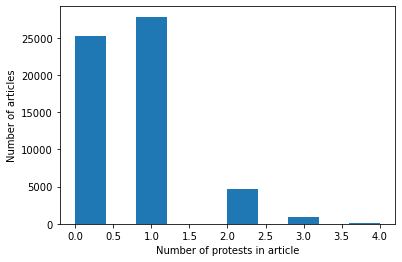

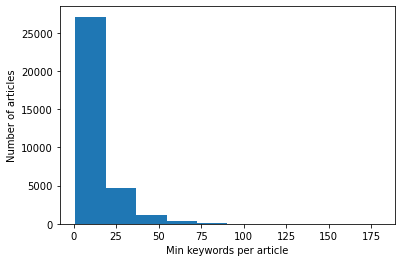

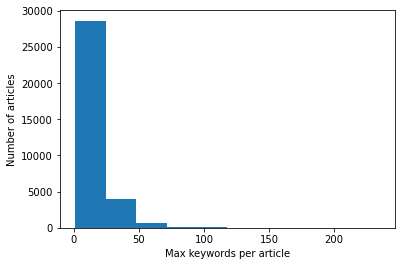

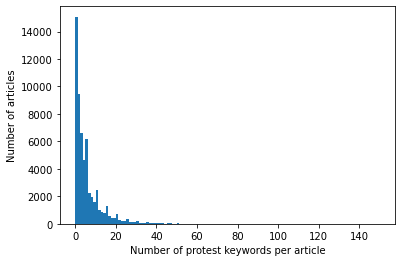

In [88]:
import matplotlib.pyplot as plt

num_protests_per_article = [len(label_count) for kw_count, label_count, _ in kw_counts]
min_kw_per_article = [min([val for _,val in label_count.items()]) for _, label_count, _ in kw_counts if label_count]
max_kw_per_article = [max([val for _,val in label_count.items()]) for _, label_count, _ in kw_counts if label_count]
protest_kws_counts = [protest_count for _, _, protest_count in kw_counts]

plt.hist(num_protests_per_article)
plt.xlabel("Number of protests in article")
plt.ylabel("Number of articles")
plt.show()

plt.hist(min_kw_per_article)
plt.xlabel("Min keywords per article")
plt.ylabel("Number of articles")
plt.show()

plt.hist(max_kw_per_article)
plt.xlabel("Max keywords per article")
plt.ylabel("Number of articles")
plt.show()

plt.hist(protest_kws_counts, bins=120)
plt.xlabel("Number of protest keywords per article")
plt.ylabel("Number of articles")
plt.show()

In [136]:
def minKeywordFilter(kw_counts , label_threshold, protest_threshold, logic = "gt"):
    _, label_counts, protest_kw_count =kw_counts 
    if label_counts:
        label_count = min([val for _,val in label_counts.items()])
        if logic == "gt":
            return label_count >= label_threshold and protest_kw_count >= protest_threshold
        elif logic == "label_lt":
            return label_count < label_threshold and protest_kw_count >= protest_threshold
        elif logic == "protest_lt":
            return label_count >= label_threshold and protest_kw_count < protest_threshold
    else:
        return False

LABEL_THRESHOLD = 5
PROTEST_THRESHOLD = 10
PROTEST_LOWER_BOUND = 2
LABEL_LOWER_BOUND = 2
article_tuples = list(zip(unfiltered_articles, processed_articles, kw_counts))
kw_filtered_articles = [article_tuple for article_tuple in article_tuples if minKeywordFilter(article_tuple[2], LABEL_THRESHOLD, PROTEST_THRESHOLD)]
removed_articles = [article_tuple for article_tuple in article_tuples if not minKeywordFilter(article_tuple[2], LABEL_THRESHOLD, PROTEST_THRESHOLD)]
low_riot_articles = [article_tuple for article_tuple in article_tuples if minKeywordFilter(article_tuple[2], LABEL_THRESHOLD, PROTEST_LOWER_BOUND, logic="protest_lt")]
low_label_articles = [article_tuple for article_tuple in article_tuples if minKeywordFilter(article_tuple[2], LABEL_LOWER_BOUND, PROTEST_THRESHOLD, logic="label_lt")]
raw_filtered_texts = [article[0]['body'] for article in kw_filtered_articles]
raw_filtered_kw = [article[2] for article in kw_filtered_articles]
print("There are {} filtered articles, {} articles with low riot content, {} articles with few labels".format(len(kw_filtered_articles), len(low_riot_articles), len(low_label_articles)))

There are 5597 filtered articles, 2819 articles with low riot content, 1579 articles with few labels


In [140]:
sample(low_riot_articles, k =1)

[({'uri': '1442273209',
   'lang': 'eng',
   'isDuplicate': False,
   'date': '2020-02-10',
   'time': '13:14:00',
   'dateTime': '2020-02-10T13:14:00Z',
   'dateTimePub': '2020-02-10T13:12:00Z',
   'dataType': 'news',
   'sim': 0,
   'url': 'https://www.scmp.com/business/china-business/article/3049887/hong-kong-cosmetic-retailer-sa-sa-closes-21-outlets-city',
   'title': 'Sa Sa closes 21 outlets in Hong Kong, Macau amid coronavirus outbreak',
   'body': 'Closure will affect about 8 per cent of the retailer\'s total sales\n\nSa Sa International Holdings, Hong Kong\'s biggest cosmetics retailer, has shut 21 stores in the city and Macau as part of cost-saving measures, as the coronavirus outbreak deters shoppers and travellers alike.\n\nThe 21 outlets closed include six in Kowloon, eight in the New Territories and three in Macau, Sa Sa said in a press release on Monday. The closure will affect about 8 per cent of the retailer\'s total sales.\n\n"The group will undertake flexible staff de

In [103]:
from random import sample

sampled_articles = sample(kw_filtered_articles, k=20)
sampled_articles = [" ".join(sampled_article[1]) for sampled_article in sampled_articles]
print(sampled_articles[0])
print(keywordCounter(preprocess_text(sampled_articles[0], stem=False), protest_specific_key_words, protest_key_words))

the latest unrest ramps up tensions in the financial hub which has been rocked by three weeks of historic demonstrations against a hugely unpopular bill that would allow extraditions to the chinese mainland tens of thousands of democracy activists staged another peaceful march on monday afternoon calling for the city's pro-beijing leader to step down and reverse what they see as years of sliding freedoms but that rally was overshadowed by small groups of mainly young masked protesters who besieged the legislature for hours sparking renewed clashes with police after two weeks of relative calm under the blazing summer sky the young demonstrators made multiple attempts to smash into the building using a metal cart as a battering ram and wielding steel poles to prize open gaps in the reinforced windows riot police appeared to have retreated deeper inside the complex or left the building which had been on lockdown an afp reporter at the scene said many of those protesting said they felt com

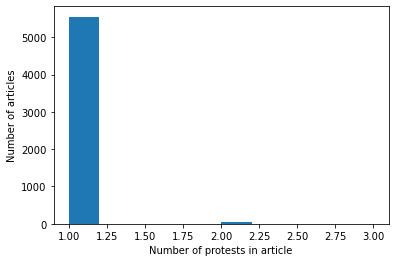

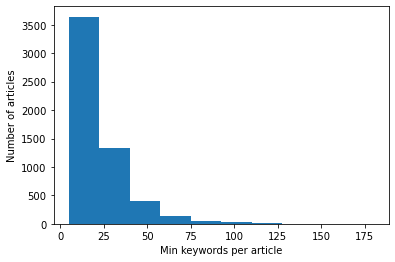

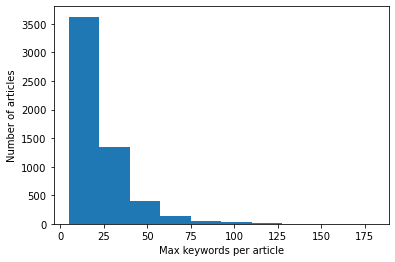

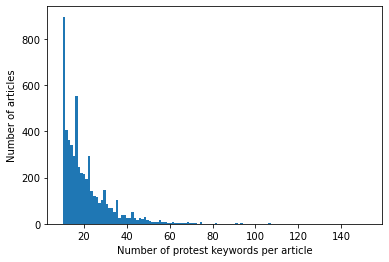

In [104]:
import matplotlib.pyplot as plt

filtered_kw_counts = [kw_count for _,_,kw_count in kw_filtered_articles]
num_protests_per_article = [len(label_count) for kw_count, label_count, _ in filtered_kw_counts]
min_kw_per_article = [min([val for _,val in label_count.items()]) for _, label_count, _ in filtered_kw_counts if label_count]
max_kw_per_article = [max([val for _,val in label_count.items()]) for _, label_count, _ in filtered_kw_counts if label_count]
protest_kws_counts = [protest_count for _, _, protest_count in filtered_kw_counts]
#min_kw_per_article = [min([val for _,val in label_count]) for _, label_count in kw_counts]


plt.hist(num_protests_per_article)
plt.xlabel("Number of protests in article")
plt.ylabel("Number of articles")
plt.show()

plt.hist(min_kw_per_article)
plt.xlabel("Min keywords per article")
plt.ylabel("Number of articles")
plt.show()

plt.hist(max_kw_per_article)
plt.xlabel("Max keywords per article")
plt.ylabel("Number of articles")
plt.show()

plt.hist(protest_kws_counts, bins=120)
plt.xlabel("Number of protest keywords per article")
plt.ylabel("Number of articles")
plt.show()

In [175]:
#corpus_tf_idfs = vectorizer.transform()


def assign_label(tupl):
    _, _, (kw, labels, _) = tupl
    if len(labels) > 1:
        return "NA"
    else:
        return [key for key in labels][0]

def score_seed(tupl):
    score = 0
    _, _, (kw, labels, _) = tupl 
    if len(labels) == 1:
        keys = [key for key in labels]
        score = labels[keys[0]]
    return score

PROTESTS = ['Venezuela', 'France', 'Hong Kong', 'Iran']

def gather_k_seeds(ranked_labelled_tuples, k =200):
    seeds = defaultdict(list)
    ranks = defaultdict(list)
    for rank, label, tupl in ranked_labelled_tuples:
        if len(seeds[label]) < k:
            seeds[label].append(tupl)
            ranks[label].append(rank)
    return seeds, ranks

SEED_SIZE = 150
scored_examples = [(score_seed(tupl), tupl) for tupl in kw_filtered_articles]
ranked_examples = sorted(scored_examples , key = lambda x: x[0], reverse=True)
ranks, ranked_examples = zip(*ranked_examples)
labels = [assign_label(tupl) for tupl in ranked_examples]
labelled_ranks = list(zip(labels,ranks))
ranked_labelled_tuples = list(zip(ranks,labels,ranked_examples))
seeds, seed_ranks = gather_k_seeds(ranked_labelled_tuples, k = SEED_SIZE)


# Add SEED_SIZE high label count articles, with few to no riot words
seeds['NA'] += sample(low_label_articles, k = SEED_SIZE//2)
# Add SEED_SIZE high riot count articles, with few labels
seeds['NA'] += sample(low_riot_articles, k = SEED_SIZE//2)



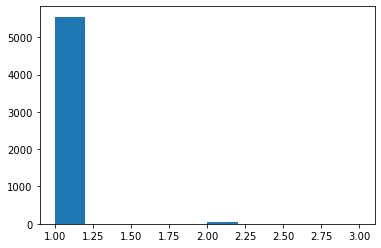

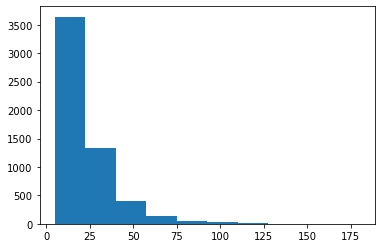

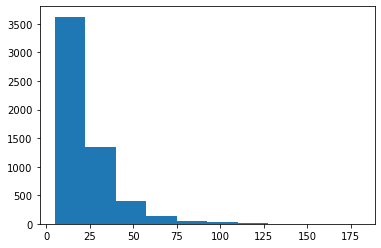

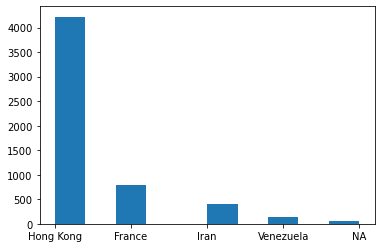

In [176]:
import matplotlib.pyplot as plt

num_protests_per_article = [len(label_count) for kw_count, label_count,_ in raw_filtered_kw]
min_kw_per_article = [min([val for _,val in label_count.items()]) for _, label_count,_ in raw_filtered_kw if label_count]
max_kw_per_article = [max([val for _,val in label_count.items()]) for _, label_count,_ in raw_filtered_kw if label_count]
#min_kw_per_article = [min([val for _,val in label_count]) for _, label_count in kw_counts]

plt.hist(num_protests_per_article)
plt.show()

plt.hist(min_kw_per_article)
plt.show()

plt.hist(max_kw_per_article)
plt.show()

plt.hist(labels)
plt.show()

In [132]:
_,texts, _ = zip(*seeds['Venezuela'])
curr_text = sample([" ".join(text) for text in texts], k =1)
print(curr_text)
print(keywordCounter(preprocess_text(curr_text[0], stem=False), protest_specific_key_words, protest_key_words))

['venezuelan forces stationed along the country\'s borders hurled tear gas at venezuela\'s opposition and activists on saturday to block their efforts to bring in food and medicine authorities are calling the aid a veiled us-backed invasion opposition volunteers in neighbouring brazil and colombia plan to arrive at the border to help carry humanitarian aid to a sick and hungry population suffering from an economic meltdown under president nicolas maduro while the need for basic food and medicines is real the effort is also meant to embarrass military officers who continue to support maduro\'s increasingly isolated government juan guaido recognised by most western nations as the country\'s legitimate head of state defied court orders not to leave venezuela by arriving on friday in the colombian border city of cucuta where aid from the us and colombian governments is stockpiled in warehouses venezuelan forces on saturday hurled tear gas and fired rubber to break up a crowd demanding to c

In [177]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# TODO: Consider adding n-grams after training the model a first time
vectorizer = TfidfVectorizer(preprocessor=lambda x: x, tokenizer = preprocess_text, stop_words=stop_words, max_features=100000)
seed_texts = [" ".join(tupl[1]) for protest, seed in seeds.items() for tupl in seed]
X = vectorizer.fit_transform(seed_texts)
# CHECK THAT ALL KEYWORDS ARE IN YOUR VOCAB
vec_line_up = [(label, key_word) for label, key_words in protest_specific_key_words.items() for key_word in key_words if key_word in vectorizer.vocabulary_]
vocab_kws = set([kw for _, kw in vec_line_up])
kw_set = set([kw for _, kws in protest_specific_key_words.items() for kw in kws])
len([kw for kw in kw_set if kw not in vocab_kws])

/home/felixlabelle3/.local/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', "it'", 'onc', 'onli', 'ourselv', "she'", "should'v", 'themselv', 'thi', 'veri', 'wa', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


27

In [178]:
from random import sample 

featurized_seeds = []
labels = []
seed_texts = []
for protest, seed in seeds.items():
    for tupl in tqdm(seed):
        featurized_seeds.append(vectorizer.transform([" ".join(tupl[1])]).toarray().flatten())
        seed_texts.append(" ".join(tupl[1]))
        labels.append(protest)

In [54]:
NUM_SEED_SAMPLES = 3
_, texts, kws = zip(*seeds['Venezuela'])
texts = [" ".join(text) for text in texts]
print(sample(list(zip(kws,texts)), k=NUM_SEED_SAMPLES))

[((defaultdict(<function keywordCounter.<locals>.<lambda> at 0x7f68e1f4b050>, {'latin': 2}), defaultdict(<function keywordCounter.<locals>.<lambda> at 0x7f68e1f4b0e0>, {'Venezuela': 2}), 13), 'earlier on friday thousands of chileans gathered in the centre of santiago for the latest in a series of rallies that initially erupted in october over a spike in transportation costs which have evolved into larger protests targeting economic and social policies hooded protesters in chile\'s capital santiago looted a roman catholic church on 8 november near plaza italia square - the main venue of weeks of mass anti-government protests the ap reports people were seen dragging religious adornments out of la asuncion church and adding them to a barricade that was set on fire the church was reportedly stripped bare as everything from church pews to statues of jesus and other religious iconography were carried out into the street with the ashes from the blaze spreading to santiago\'s plaza italia squa

In [179]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split( featurized_seeds, labels, test_size=0.2, random_state=42)
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.score(X_train, y_train)

0.9599358974358975

In [180]:
from sklearn.metrics import f1_score,classification_report

clf.score(X_test, y_test)
y_preds = clf.predict(X_test)
f1_score(y_test, y_preds, average='weighted')
classification_report(y_test, y_preds)

'              precision    recall  f1-score   support\n\n      France       0.94      1.00      0.97        29\n   Hong Kong       0.93      0.93      0.93        30\n        Iran       0.93      1.00      0.97        28\n          NA       0.89      0.81      0.85        42\n   Venezuela       0.93      0.93      0.93        28\n\n    accuracy                           0.92       157\n   macro avg       0.93      0.93      0.93       157\nweighted avg       0.92      0.92      0.92       157\n'

In [181]:
print("Extracting features over entire dataset")
article_features = [vectorizer.transform([article]) for article in tqdm(raw_articles)]

Extracting features over entire dataset


In [182]:
article_scores = [clf.predict_proba(article_feature.toarray()) for article_feature in tqdm(article_features)]
article_preds = [clf.predict(article_feature.toarray()) for article_feature in tqdm(article_features)]

In [92]:
sum([val for _, val in Counter([pred[-1] for _,_,pred in thresholded_articles]).items()])

13980

In [183]:
from collections import Counter

# Come up with a thresholding scheme
MIN_CONFIDENCE = 0
# Remove weak candidates
thresholded_articles =  [(article, score.tolist(), pred[0]) for article, score, pred in zip(unfiltered_articles, article_scores, article_preds) if score.max() >= MIN_CONFIDENCE and pred != "NA"]
# Label the remaining articles
# Check stats (Protests, KWs, etc..)
highest_NA = sorted(list(zip(article_scores, raw_articles)), key=lambda x : x[0][0][-2], reverse=True)
highest_NA[95:100]

article_counts = Counter([pred for _,_,pred in thresholded_articles])
print(article_counts, sum([val for _, val in article_counts.items()]))

Counter({'Hong Kong': 3847, 'Iran': 1863, 'Venezuela': 1853, 'France': 1627}) 9190


In [40]:
list(zip(article_scores, raw_articles))[0][-1]
clf.classes_

array(['France', 'Hong Kong', 'Iran', 'NA', 'Venezuela'], dtype='<U9')

In [184]:
with open('filtered_data_v5.json', 'w+') as filtered_data_fh:
    json.dump(thresholded_articles, filtered_data_fh)